In [14]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
mpl.rcParams['figure.dpi'] = 300

import seaborn as sns

from sklearn.manifold import TSNE

# Inter-subject RSA: Theory & simulations

- “Model-free” analyses that exploit the time-locked nature of a stimulus across subjects—e.g., inter-subject correlation (ISC) and related approaches—are a powerful way to analyze naturalistic neuroimaging data
- These approaches reveal spatiotemporal patterns of brain activity that are common across subjects
- However, brain activity during naturalistic stimuli also shows interesting individual differences

### Q: Can we develop & extend inter-subject approaches to study what is **different** across subjects, rather than what is common?

One problem is that ISC by definition operates at the level of subject pairs, while traits and behaviors operate at the level of single subjects. So, how can we relate ISC (one measure per subject pair) to behavior (one measure per subject)?

A. Representational similarity analysis!

If we take our subjects-by-subjects ISC matrix to be a "brain similarity" matrix, we can construct a "behavioral similarity" matrix and use RSA to find brain regions where subjects who are more similar in their behavior are also more similar in their neural response.

Sounds straightforward on its face, but when we talk about "similarity" between a given subject pair, not all similarity measures are created equal. Let's do some simuluations and visualizations to illustrate this.

In [15]:
# First, choose number of subjects and simulate behavior chosen from random distribution
n_subs = 100
behav = np.random.randn(n_subs)
behav_rank = sp.stats.rankdata(behav)-1

cmap = plt.cm.get_cmap('RdYlBu_r')
cmap.set_bad('#C0C0C0')

# Define some helper functions s
def sort_square_mtx(mtx, behav_vct):
    """
    Sorts rows/columns of a matrix according to a separate vector.
    """
    
    inds = behav_vct.argsort()
    mtx_sort = mtx
    mtx_sort = mtx_sort[inds, :]
    mtx_sort = mtx_sort[:, inds]
    
    return mtx_sort

def scale_mtx(mtx):
    """
    Scales a matrix to be between 0 and 1.
    """
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))

In a typical RSA analysis, we would use something like Euclidean distance (or its inverse, so we can talk about similarity rather than distance). However, this makes a big assumption, namely that if two subjects score close to one another on the scale -- irrespective of whether they score high or low -- we expect them to look more similar to one another than two subjects whose scores are far apart. In other words, this would be a "nearest neighbor" scenario, where all that matters is your relative distance from your partner, and not where you score in an absolute sense.

If we visualize the sorted subjects x subjects ISC matrix, it would look like this (warmer colors indicate greater similarity):

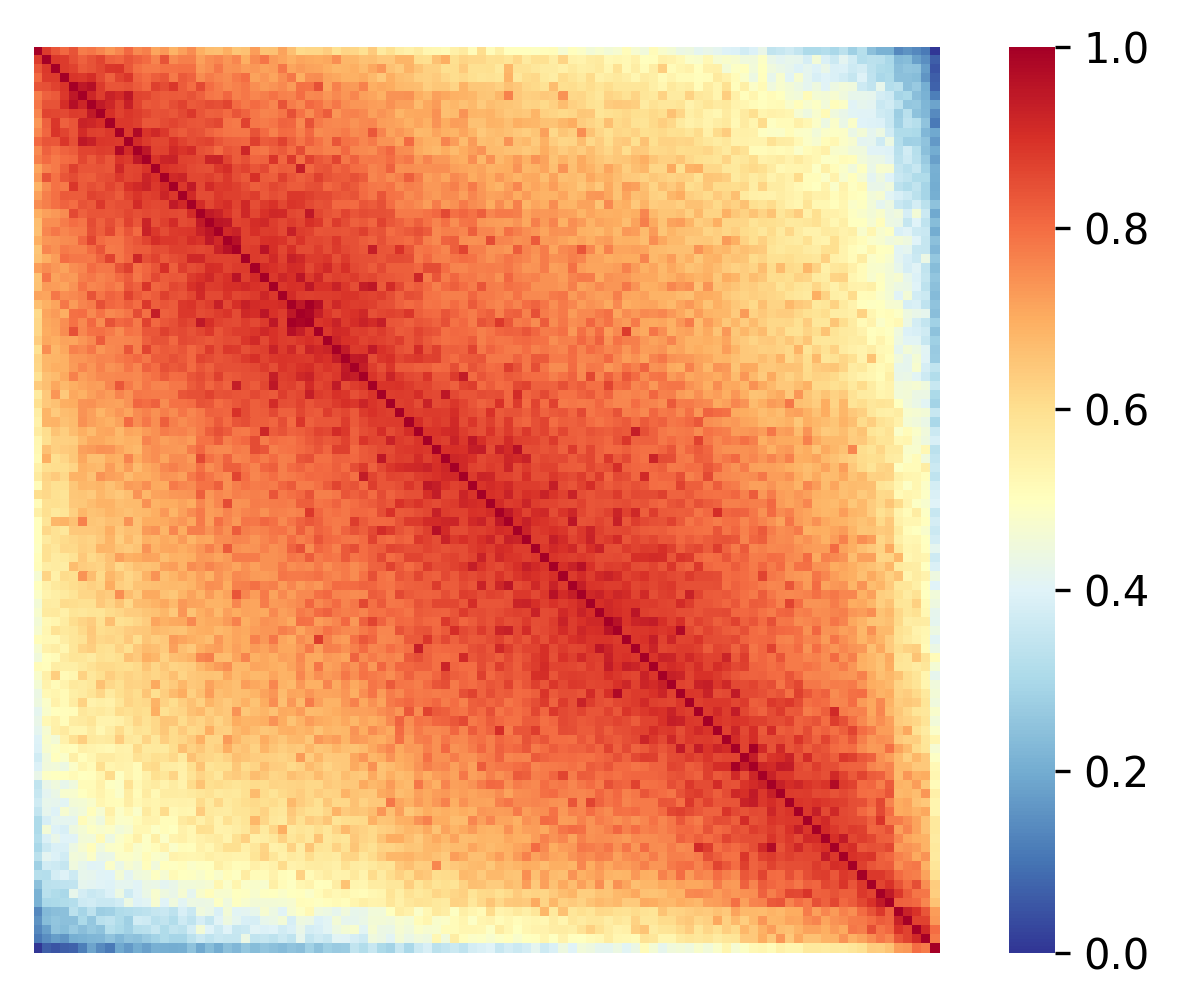

In [16]:
nn_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.2

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = 1-abs(behav[i]-behav[j]) + abs(np.random.randn()*noise_factor)
            nn_mtx[i,j] = tmp
            nn_mtx[j,i] = tmp
            
nn_mtx = scale_mtx(nn_mtx)
np.fill_diagonal(nn_mtx, 1)    

fig, ax = plt.subplots()
sns.heatmap(sort_square_mtx(nn_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

Or, if it's just the relative score (rank) that matters, it would look like this:

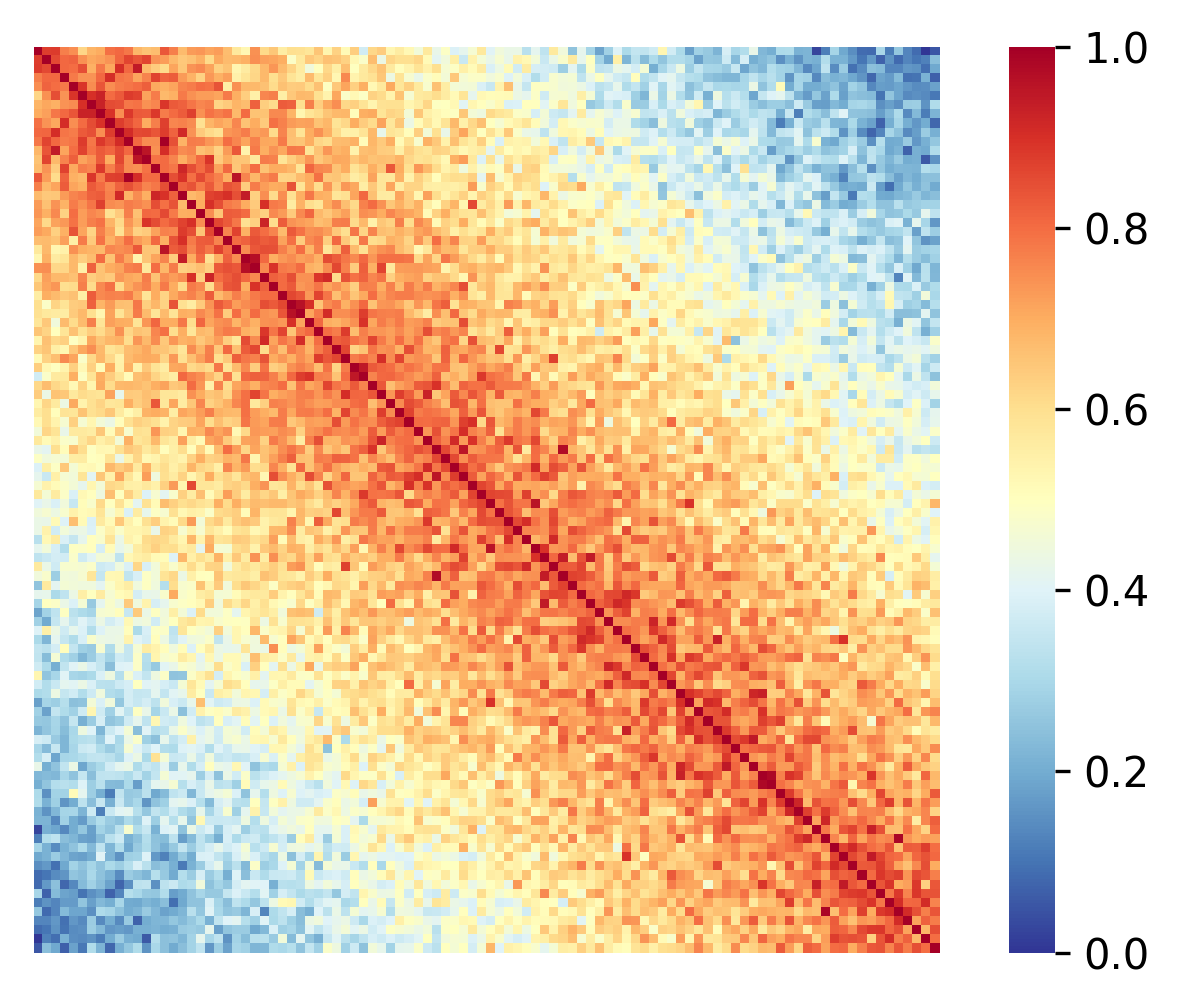

In [17]:
nn_rank_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = 1-(abs(behav_rank[i]-behav_rank[j])/n_subs) + np.random.randn()*noise_factor
            nn_rank_mtx[i,j] = tmp
            nn_rank_mtx[j,i] = tmp
            
nn_rank_mtx = scale_mtx(nn_rank_mtx)
np.fill_diagonal(nn_rank_mtx, 1)    

fig, ax = plt.subplots()
sns.heatmap(sort_square_mtx(nn_rank_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
# ax.set_title("Nearest neighbor\n(model: Euclidean distance(i,j))")

But what if that's not the case? What if the absolute position on the scale *does* matter, such that subjects that are high scoring look more similar to other high scorers, but less similar to low scorers? I call this the "Anna Karenina" scenario, since the most succinct way to describe is that "all high scorers are alike, all low scorers are low-scoring in their own way" (mirroring the famous opening quote from that novel, which reads "All happy families are alike; all unhappy families are unhappy in their own way"). 

Now if we visualize the matrix, it would look like this:

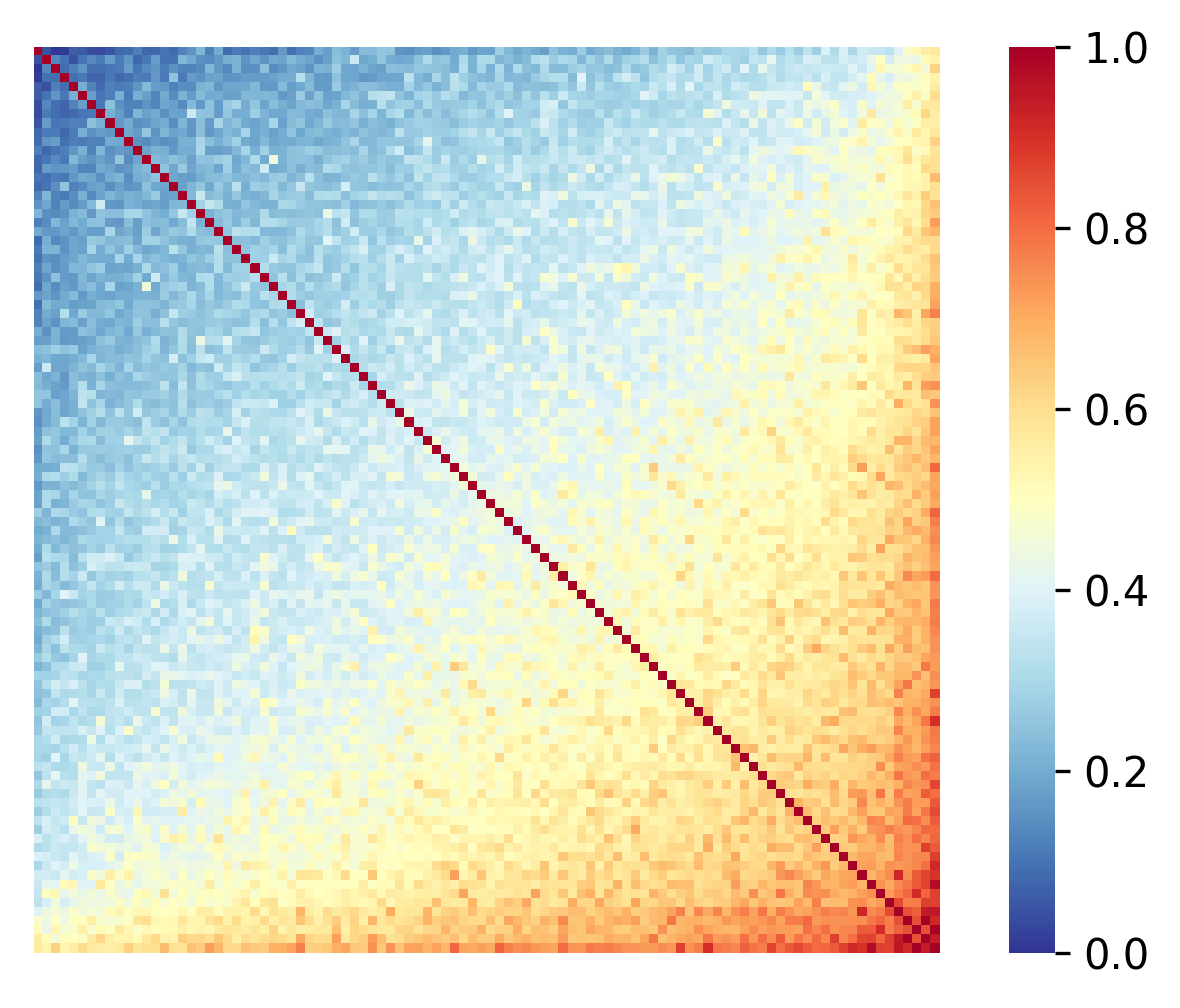

In [18]:
ak1_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = np.mean([behav[i]/max(behav), behav[j]/max(behav)]) + abs(np.random.randn()*noise_factor)
            ak1_mtx[i,j] = tmp
            ak1_mtx[j,i] = tmp

ak1_mtx = scale_mtx(ak1_mtx)
np.fill_diagonal(ak1_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(ak1_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

Or, again based on ranks:

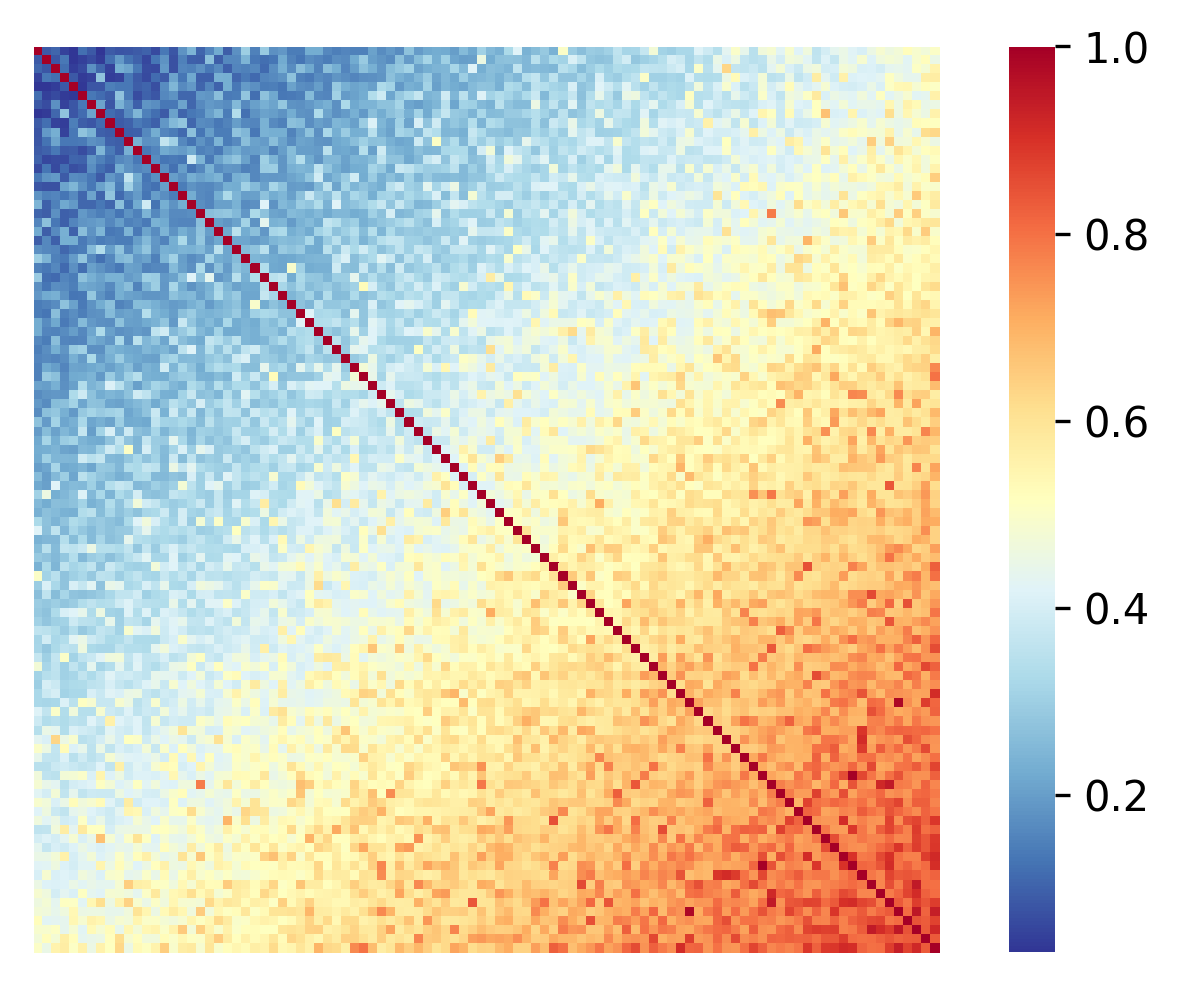

In [19]:
ak1_rank_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.1

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = np.mean([behav_rank[i]/n_subs, behav_rank[j]/n_subs]) + abs(np.random.randn()*noise_factor)
            ak1_rank_mtx[i,j] = tmp
            ak1_rank_mtx[j,i] = tmp

ak1_rank_mtx = scale_mtx(ak1_rank_mtx)
np.fill_diagonal(ak1_rank_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(ak1_rank_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

Of course, it would also be possible to have the reverse scenario, i.e., all *low* scorers are alike, whereas all *high* scorers are less similar to both one another and to low scorers. 

Or it could be a sharper-looking matrix, where high-low pairs do *not* show intermediate similarity between high-high and low-low pairs:

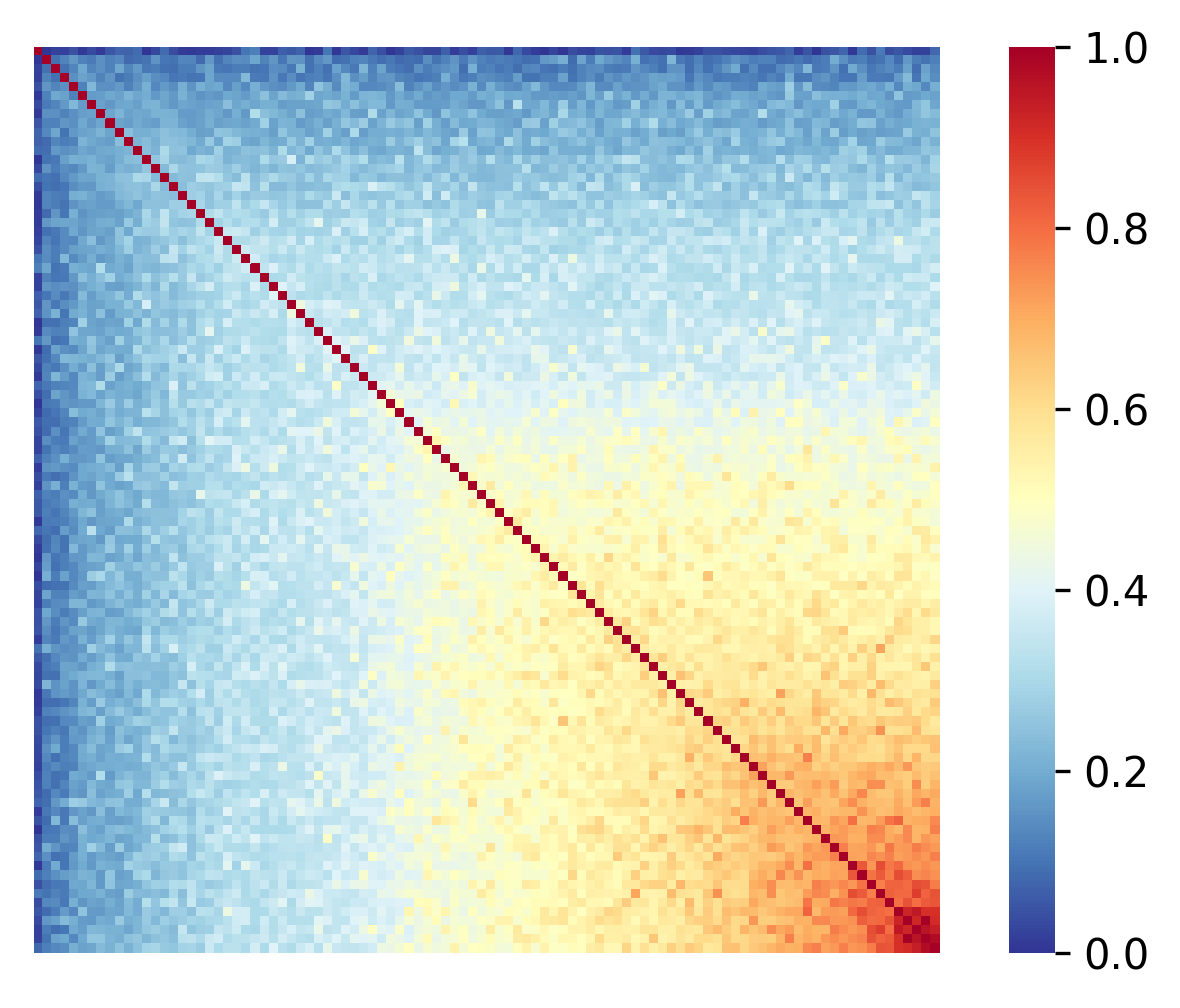

In [20]:
ak2_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.2

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = (min(behav[i], behav[j])  + abs(np.random.randn()*noise_factor) )/n_subs
            ak2_mtx[i,j] = tmp
            ak2_mtx[j,i] = tmp
            
ak2_mtx = scale_mtx(ak2_mtx)
np.fill_diagonal(ak2_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(ak2_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

Using ranks:

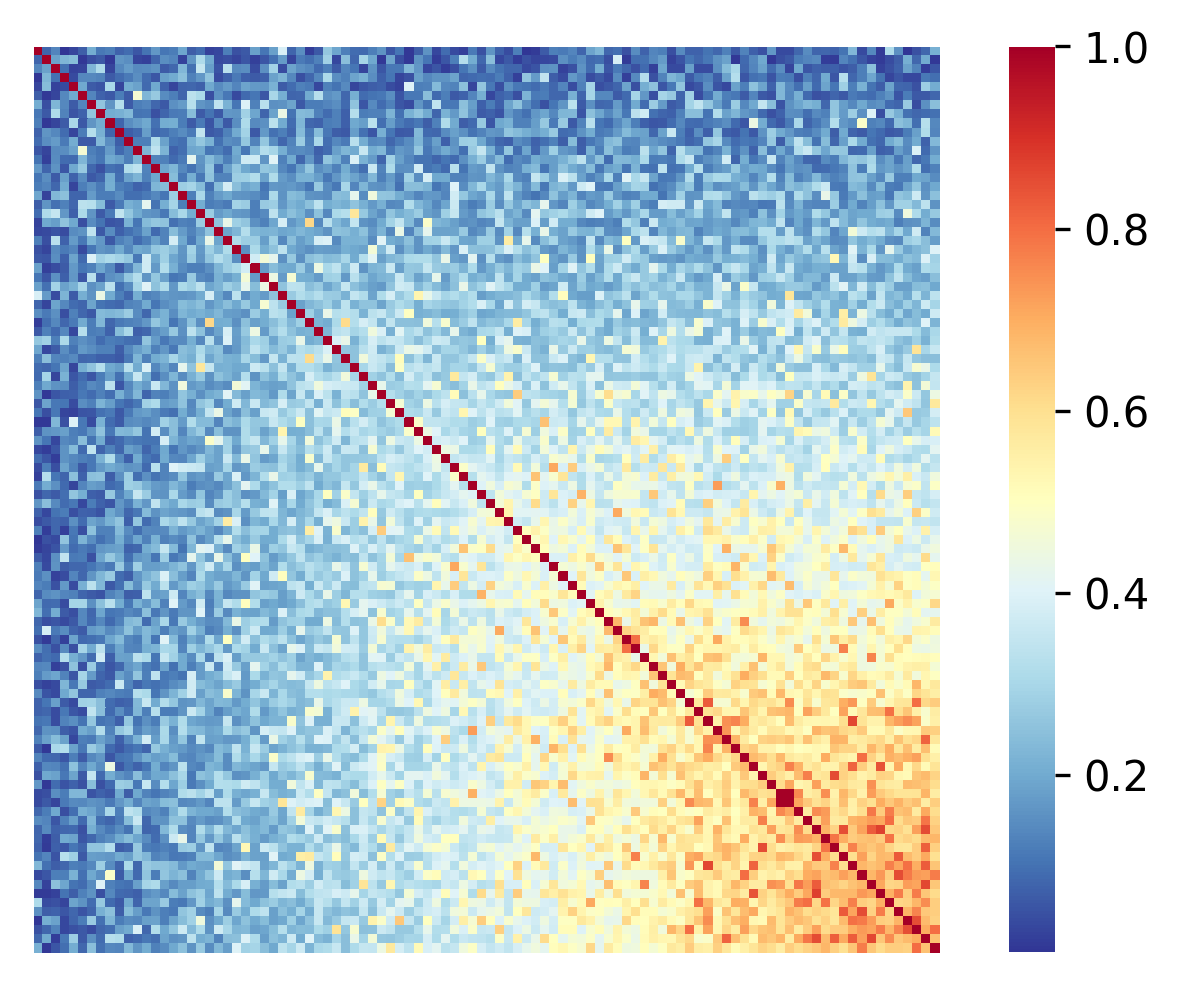

In [21]:
ak2_rank_mtx = np.zeros((n_subs, n_subs))
noise_factor = 0.2

for i in range(n_subs):
    for j in range(n_subs):
        if i < j:
            tmp = min(behav_rank[i], behav_rank[j])/n_subs + abs(np.random.randn()*noise_factor)
            ak2_rank_mtx[i,j] = tmp
            ak2_rank_mtx[j,i] = tmp
            
ak2_rank_mtx = scale_mtx(ak2_rank_mtx)
np.fill_diagonal(ak2_rank_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(ak2_rank_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

Finally, there could be an effect of a slightly different shape, where there is still more variance among the low scorers than high scorers, but rather than radiating out randomly the low scorers are all "pulled" in a similar direction (this is easier to see in the t-SNE plots below, rather than the ISC matrices):

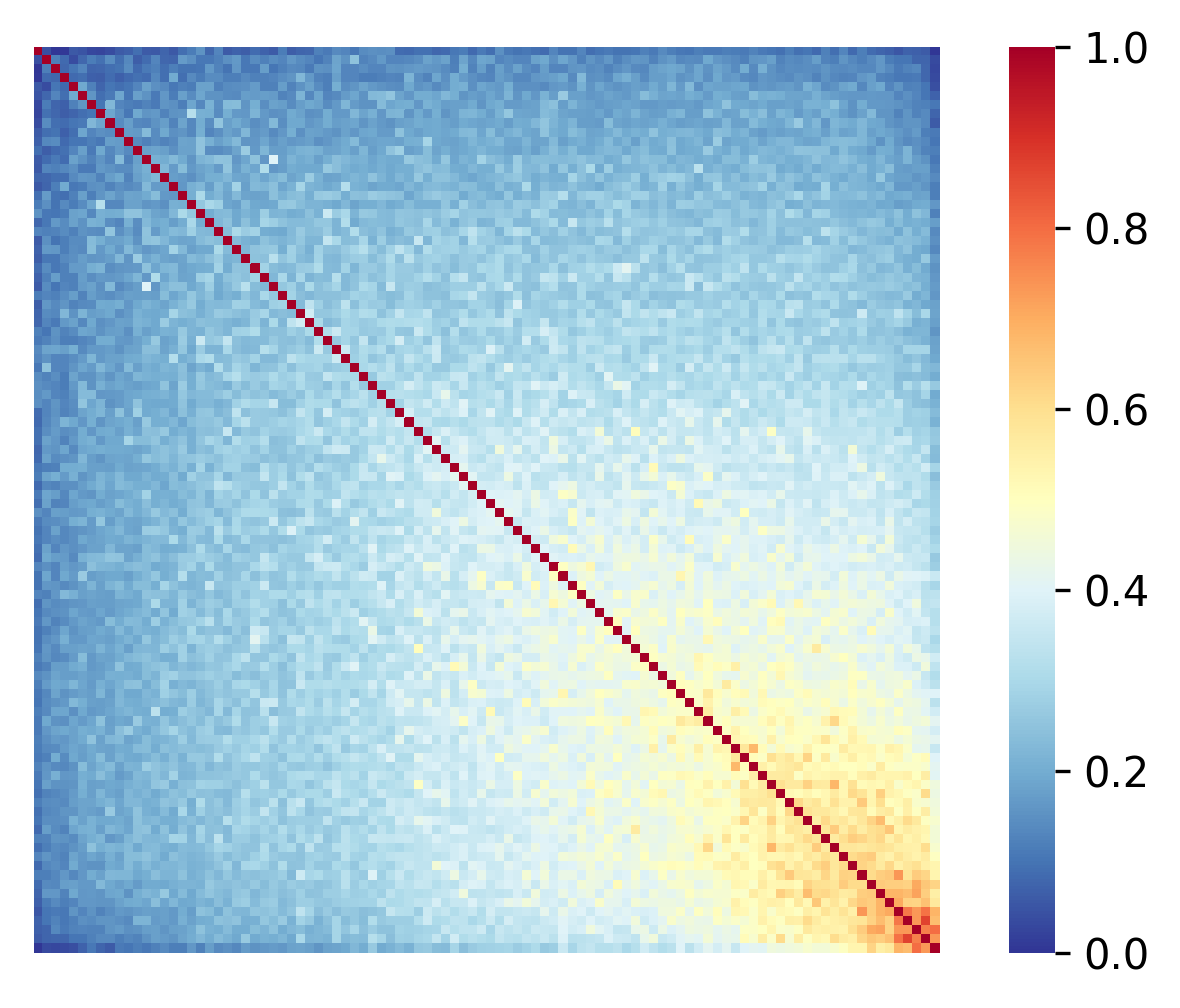

In [22]:
combo_mtx = np.multiply(nn_mtx,ak1_mtx)

combo_mtx = scale_mtx(combo_mtx)
np.fill_diagonal(combo_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(combo_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

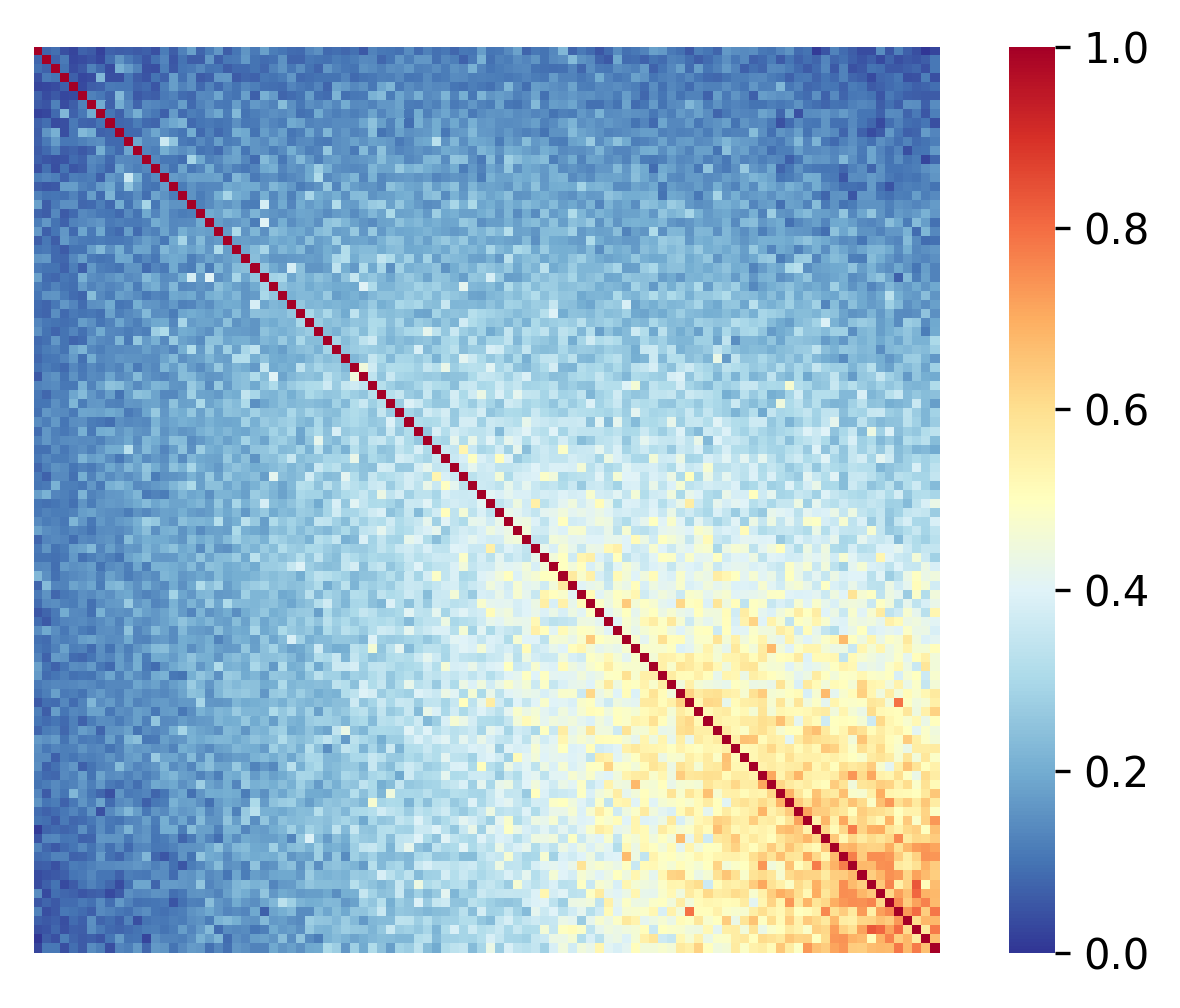

In [23]:
combo_rank_mtx = np.multiply(nn_rank_mtx,ak1_rank_mtx)

combo_rank_mtx = scale_mtx(combo_rank_mtx)
np.fill_diagonal(combo_rank_mtx, 1)

fig, ax = plt.subplots()

# Draw heatmap
sns.heatmap(sort_square_mtx(combo_rank_mtx, behav), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)

### We can convert these similarity matrices to distance matrices and visualize them in two dimensions using t-SNE embedding, which gives an even clearer picture of the relationships between high and low scorers:

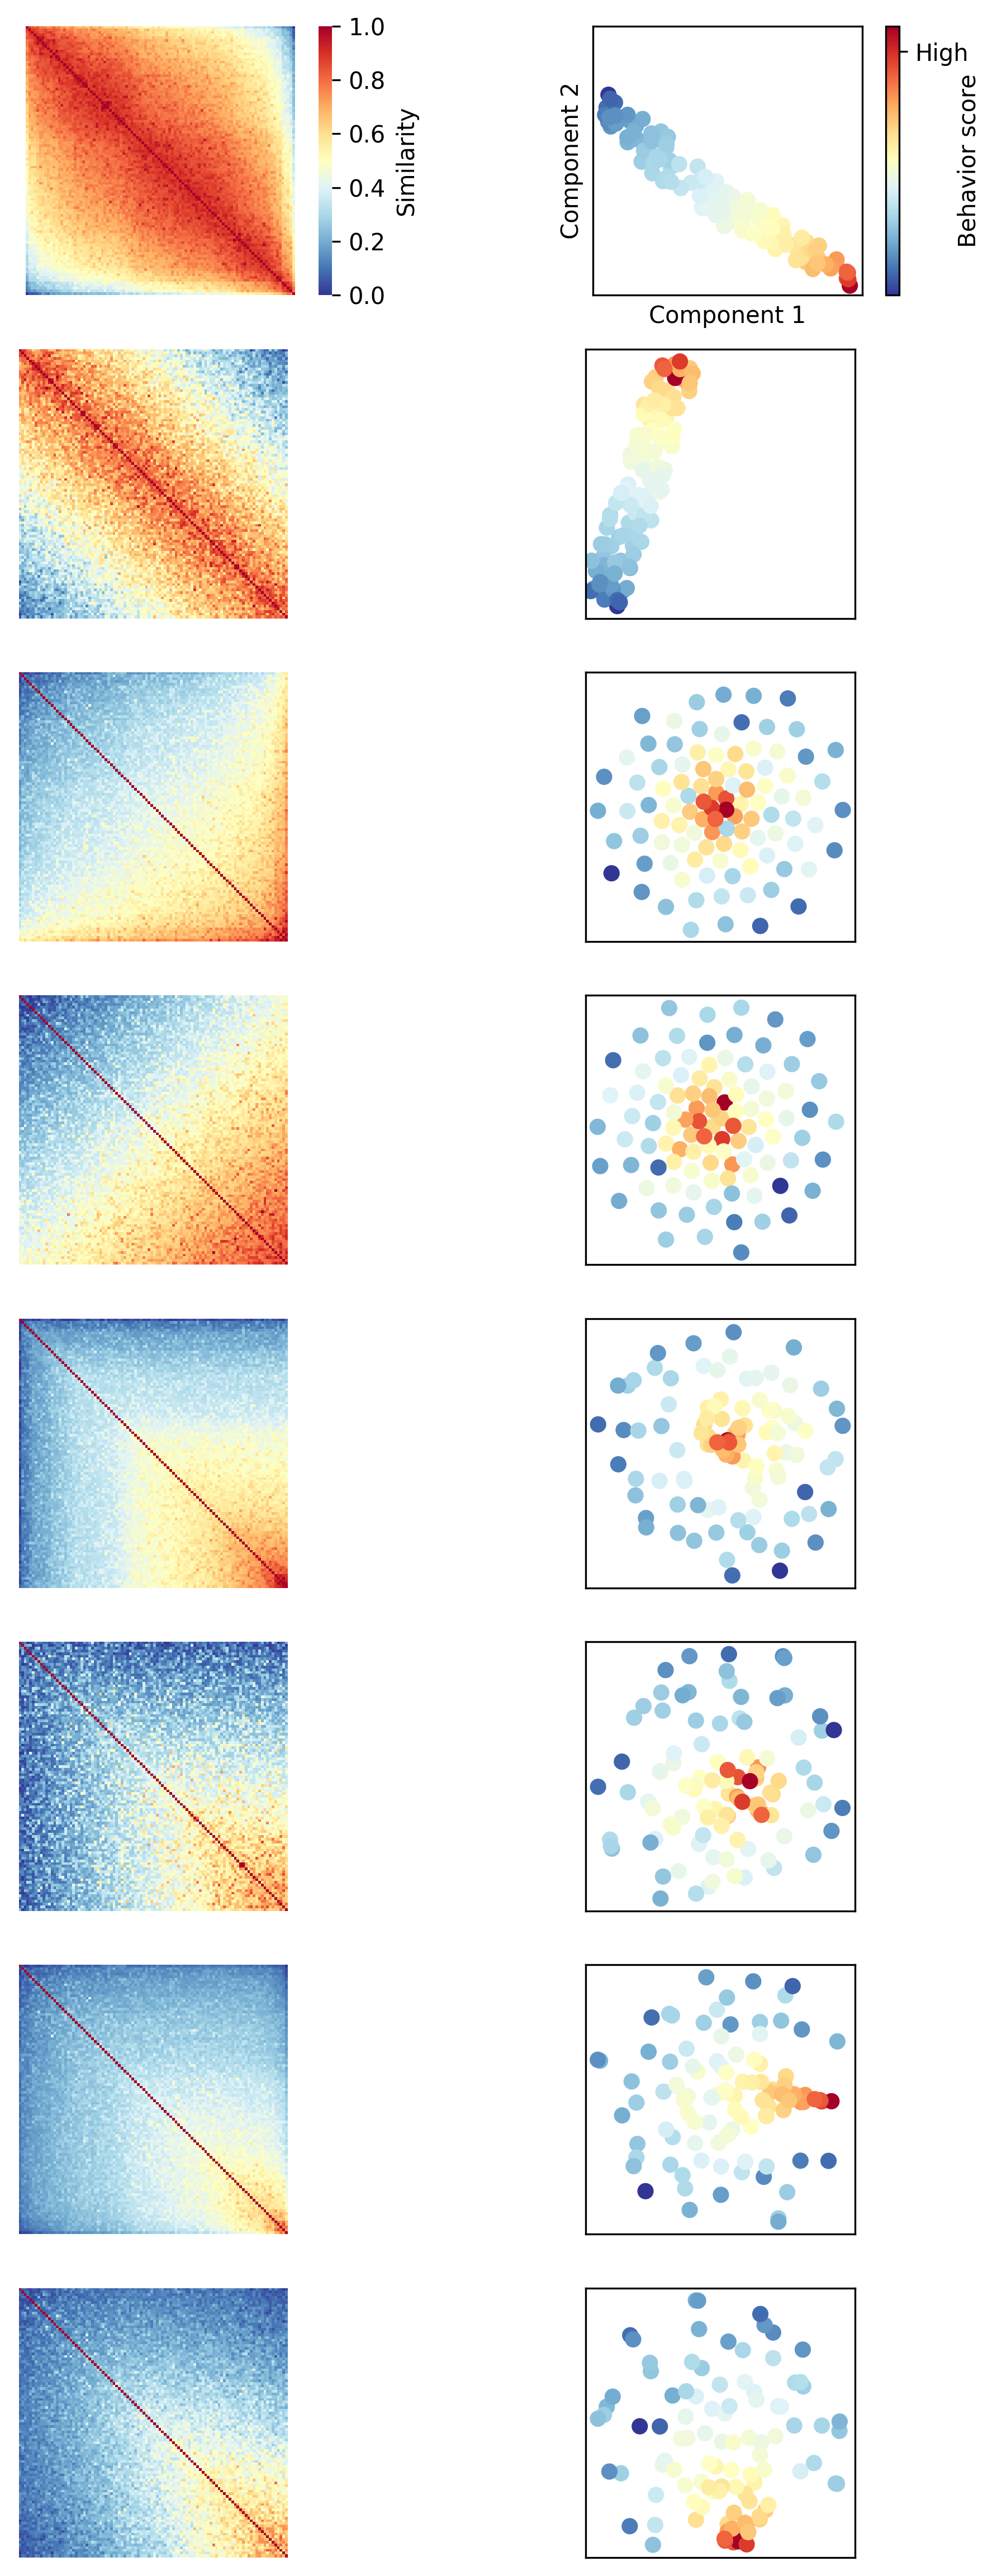

In [24]:
list_of_matrices = [nn_mtx, nn_rank_mtx, ak1_mtx, ak1_rank_mtx, ak2_mtx, ak2_rank_mtx, combo_mtx, combo_rank_mtx]

fig, axes = plt.subplots(len(list_of_matrices), 2, figsize = (8,20))

for m, mtx in enumerate(list_of_matrices):
    ax1 = axes[m, 0]
    ax2 = axes[m, 1]
    
    # Draw heatmap
    if m ==0:
        cbar = True
    else:
        cbar = False
        
    sns.heatmap(sort_square_mtx(mtx, behav), ax=ax1, 
                cmap=cmap, square=True, cbar=cbar, cbar_kws = {'label': 'Similarity'},
                xticklabels=False, yticklabels=False)
    
    # Draw tSNE plot
    isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1-mtx)
    sp = ax2.scatter(isc_embedded[:,0], isc_embedded[:,1], c=behav, cmap=cmap)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    if m ==0:
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')
        # cbar.ax2.set_xticklabels(['Low', 'High'])
        
    ax2.axis('square')
    ax2.set(xlim = ax2.get_xlim(), ylim = ax2.get_ylim())

cbar = fig.colorbar(sp, ax = axes[0,1], ticks = [-2, 2])
cbar.ax.set_yticklabels(['Low', 'High'])
cbar.set_label('Behavior score', labelpad = -5)

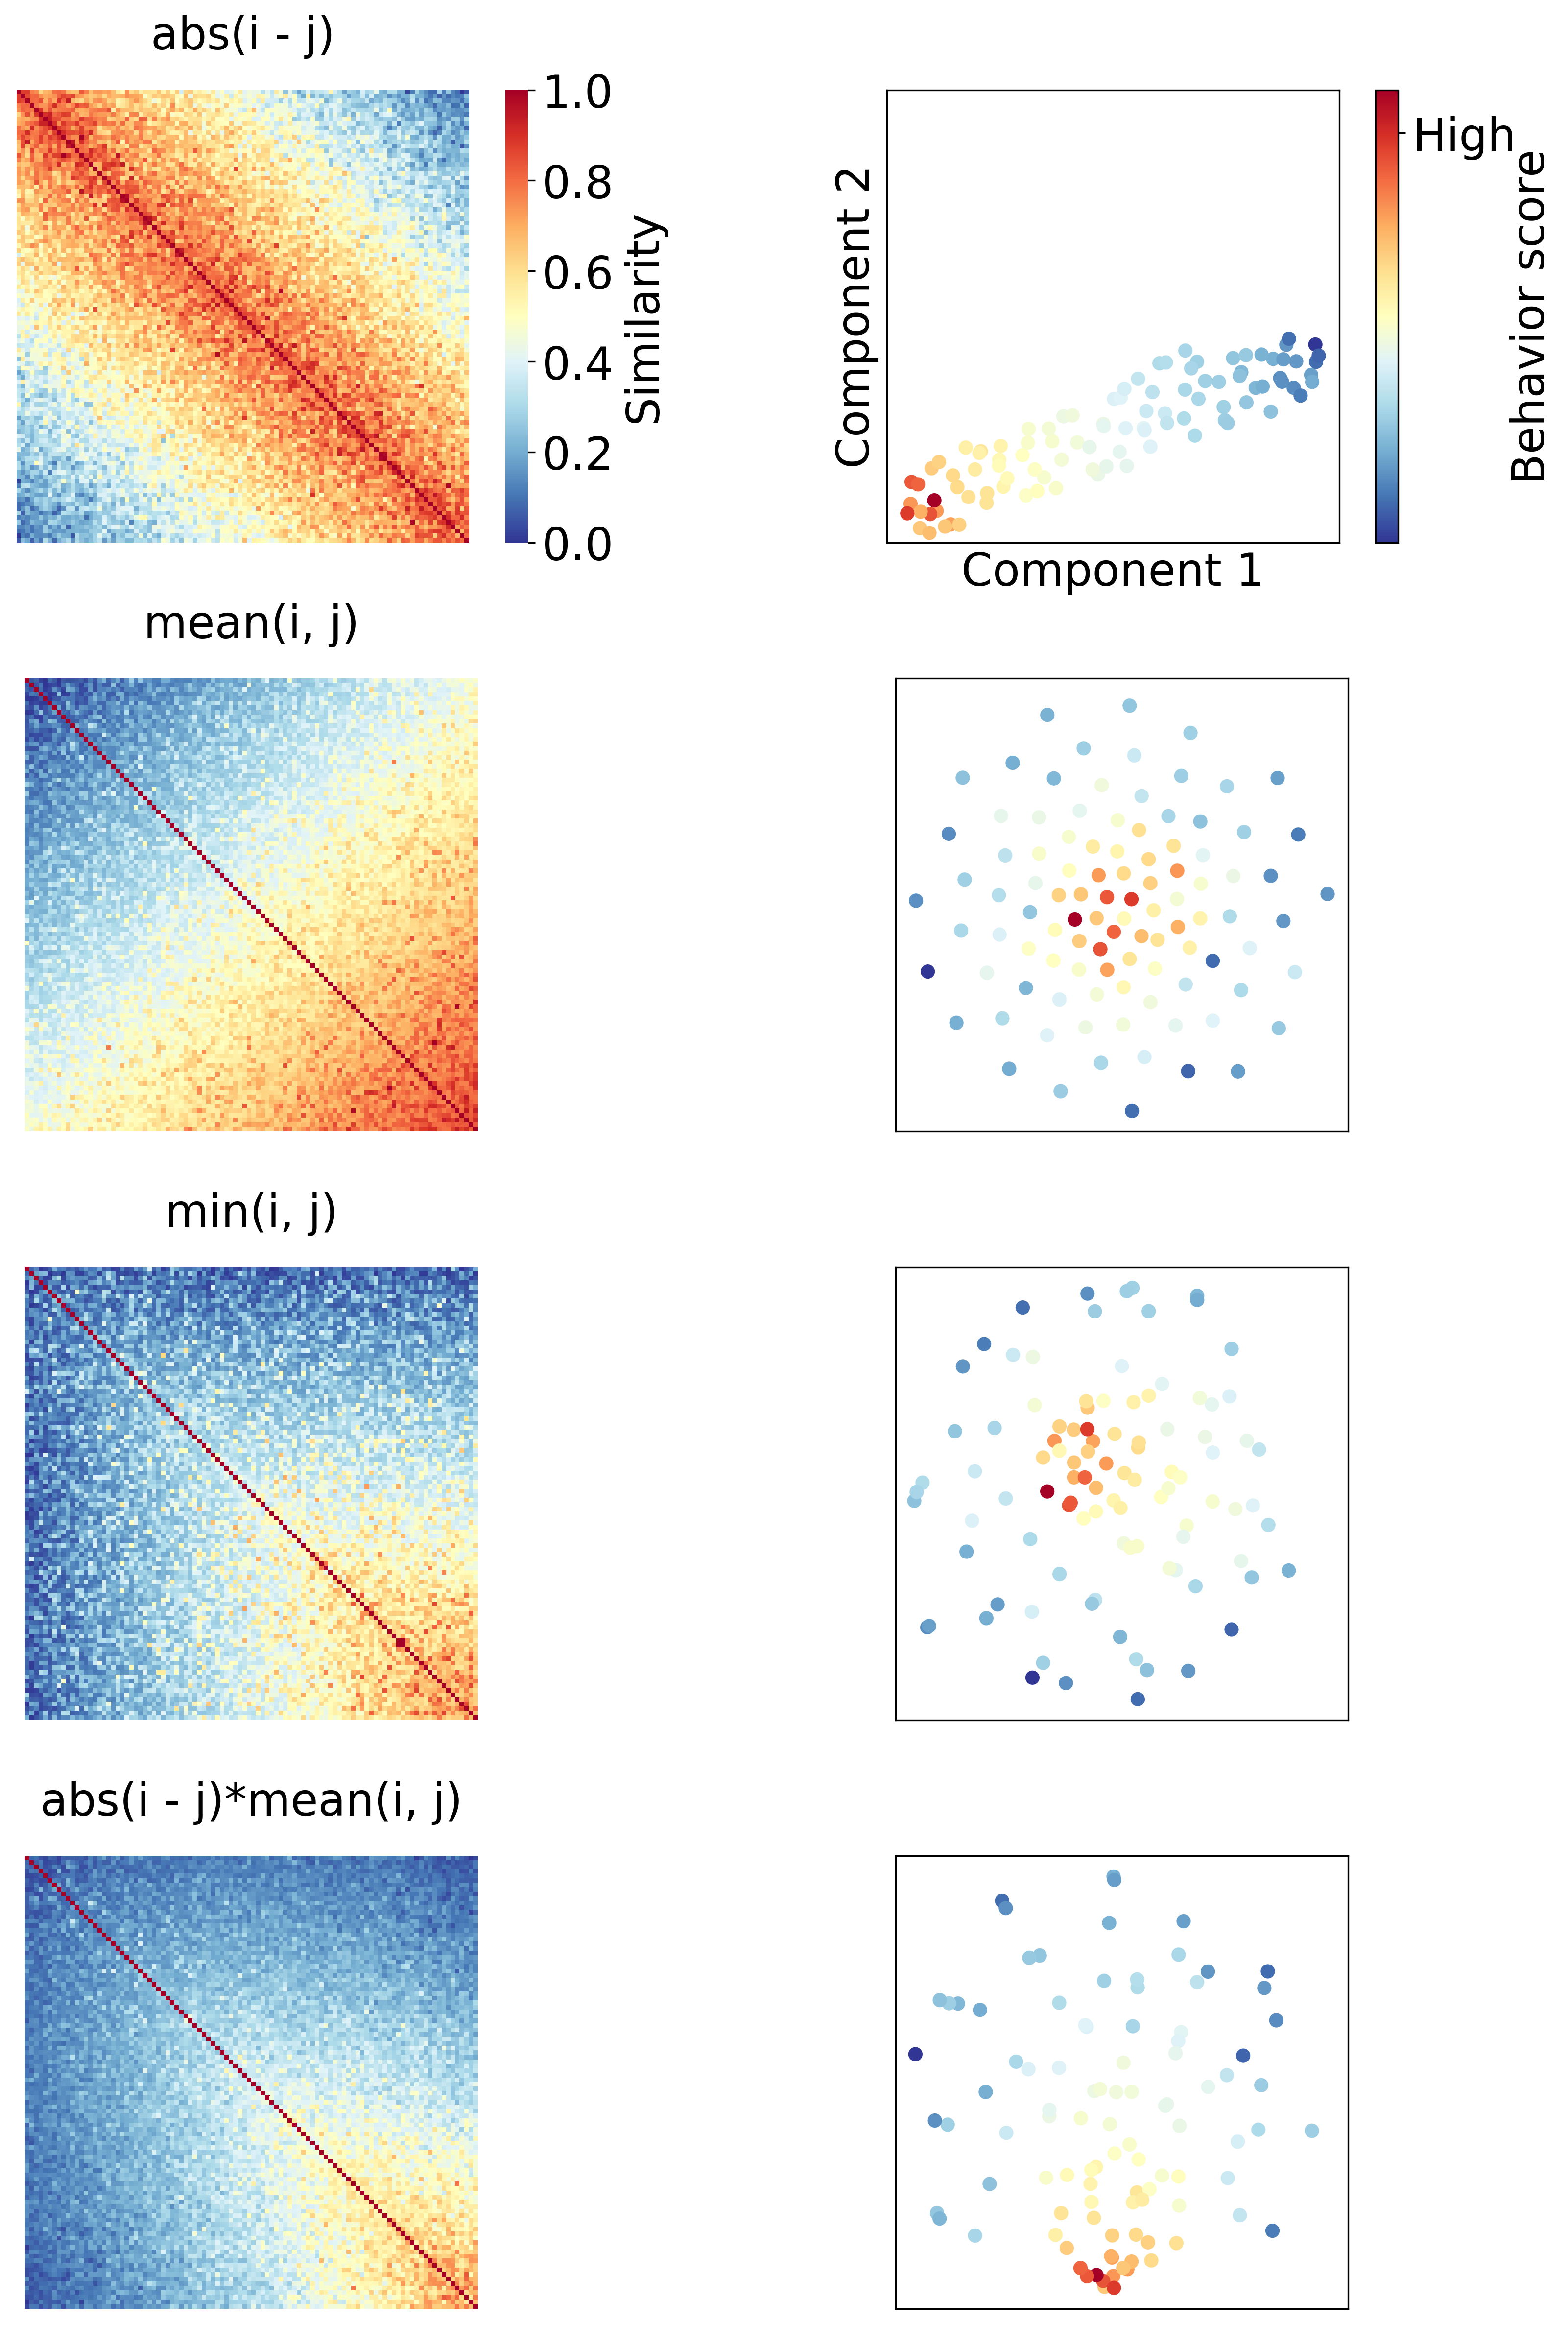

In [25]:
list_of_matrices = [nn_rank_mtx, ak1_rank_mtx, ak2_rank_mtx, combo_rank_mtx]

fig, axes = plt.subplots(len(list_of_matrices), 2, figsize = (12,20))
pad = 20
fontsize=22

for m, mtx in enumerate(list_of_matrices):
    ax1 = axes[m, 0]
    ax2 = axes[m, 1]
    
    # Draw heatmap
    if m ==0:
        cbar = True
    else:
        cbar = False
        
    sns.heatmap(sort_square_mtx(mtx, behav), ax=ax1, 
                cmap=cmap, square=True, cbar=cbar, cbar_kws = {'label': 'Similarity'},
                xticklabels=False, yticklabels=False)
    
    ax1.figure.axes[-1].yaxis.label.set_size(fontsize)
    ax1.figure.axes[-1].tick_params(axis="y", labelsize=fontsize)
    
    # Draw tSNE plot
    isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1-mtx)
    sp = ax2.scatter(isc_embedded[:,0], isc_embedded[:,1], c=behav, cmap=cmap)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    if m ==0:
        ax2.set_xlabel('Component 1', fontsize=fontsize)
        ax2.set_ylabel('Component 2', fontsize=fontsize)
        # cbar.ax2.set_xticklabels(['Low', 'High'])
        
    ax2.axis('square')
    ax2.set(xlim = ax2.get_xlim(), ylim = ax2.get_ylim())

cbar = fig.colorbar(sp, ax = axes[0,1], ticks = [-2, 2])
cbar.ax.set_yticklabels(['Low', 'High'], fontsize=fontsize)
cbar.set_label('Behavior score', labelpad = -3, fontsize=fontsize)

axes[0,0].set_title("abs(i - j)", pad=pad, fontsize=fontsize)
axes[1,0].set_title("mean(i, j)", pad=pad, fontsize=fontsize)
axes[2,0].set_title("min(i, j)", pad=pad, fontsize=fontsize)
axes[3,0].set_title("abs(i - j)*mean(i, j)", pad=pad, fontsize=fontsize)

# fig.tight_layout()
fig.subplots_adjust(hspace = 0.3)
plt.subplots_adjust(right = 1.03)
# fig.tight_layout()


In [26]:
fname = 'isRSA_simulation'

# fig.savefig(fname,dpi=300, bbox_inches="tight")